In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm

import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load the MNIST dataset and split it into the train, eval, and test set

In [3]:
dataset = MNIST(root='./',
                transform=transforms.ToTensor(),
                download=True)


In [4]:
test_set = MNIST(root='./',
                train=False,
                transform=transforms.ToTensor(),
                download=True)

### Visualize data

In [5]:
%matplotlib inline
sns.set()

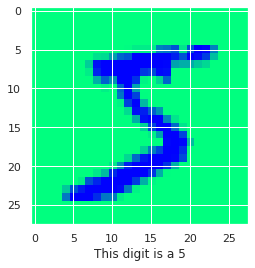

In [6]:
image = dataset[0][0][-1, :, :]
label = dataset[0][1]

plt.imshow(image, cmap='winter_r')
plt.xlabel(f"This digit is a {label}")
plt.show()

In [14]:
def binary_targets(dataset):
    """
    Change the targets to binary
    Digit 4 -> 1
    All other digits -> 0
    """
    
    dataset.targets[dataset.targets != 4] = 0
    dataset.targets[dataset.targets == 4] = 1
    


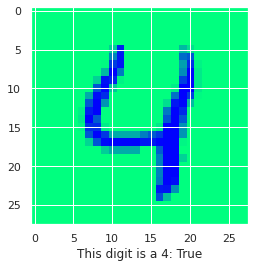

In [28]:
image = test_set[4][0][-1, :, :]
label = bool(test_set[4][1])

plt.imshow(image, cmap='winter_r')
plt.xlabel(f"This digit is a 4: {label}")
plt.show()

In [16]:
binary_targets(dataset)
binary_targets(test_set)

The available MNIST dataset does not contain a validation set.
To prevent overfitting, I will create a validation set by slicing 10 000 images from the training set.

In [9]:
train_indices = torch.arange(len(dataset)-10000)
val_indices = torch.arange(len(dataset)-10000, len(dataset))
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)

## Create a custom multi-image dataset from MNIST

average 10
images with standard deviation of 3, but no less than 3 and no more than 30.

In [10]:
def create_dataset_shape(size, mean=10, sd=3, low=3, upp=30):
    trunc = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    trunc_array = torch.from_numpy(trunc.rvs(size))
    return torch.round(trunc_array)

In [11]:
train_shape = create_dataset_shape(5000)
val_shape = create_dataset_shape(1000)
test_shape = create_dataset_shape(1000)

In [12]:
#assert train_shape.sum() <= len(train_set)
#assert val_shape.sum() <= len(val_set)
#assert test_shape.sum() <= len(test_set)